### Introduction

The aim of this project will be to predict the the payment default for the next months for the given credits based on different demographic variables. In order to achieve it, we are going to analyze the influence of each variable and we are going to use different machine learning algorithms to get the best possible predictions.

In [105]:
import pandas as pd

import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score , mean_squared_error,confusion_matrix , classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import GridSearchCV
import pickle
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [106]:
df_credit=pd.read_csv("default of credit card clients.csv")

#### INFORMATION ABOUT THE DATA

*LIMIT_BAL*: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.

*SEX*: Gender (1 = male; 2 = female).

*EDUCATION*: Education (1 = graduate school(Master or Doctor degree's); 2 = university; 3 = high school; 4 = others).

*MARRIAGE*: Marital status (1 = married; 2 = single; 3 = others(Outlayers | Gays)).

*AGE*: Age (year).

*PAY_1-PAY_6*: History of past payment. We tracked the past monthly payment recordsfrom April to September, 2005 as follows:

PAY_1 = the repayment status in September, 2005; PAY_2 = the repayment status in August, 2005; . . .;PAY_6 = the repayment status in April, 2005. The measurement scale for the repayment status is:

-2: No consumption; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

*BILL_AMT1–BILL_AMT6*: Amount of bill statement (NT dollar).

BILL_AMT1 = amount of bill statement in September 2005, BILL_AMT2 = amount of bill statement in August 2005, BILL_AMT6 = amount of bill statement in April 2005.

*PAY_AMT1-PAY_AMT6*: Amount of previous payment (NT dollar).

PAY_AMT1 = amount paid in September 2005, PAY_AMT2 = amount paid in August 2005, PAY_AMT6 = amount paid in April 2005.

**dpnm**: default payment next month. Our target variable (our *y*). The value we want to predict. y=0 then not default, y=1 then default.

In [107]:
df_credit.info() # as we can see in the information below, the data is already clean and we have no null values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         30000 non-null  int64
 1   LIMIT_BAL  30000 non-null  int64
 2   SEX        30000 non-null  int64
 3   EDUCATION  30000 non-null  int64
 4   MARRIAGE   30000 non-null  int64
 5   AGE        30000 non-null  int64
 6   PAY_1      30000 non-null  int64
 7   PAY_2      30000 non-null  int64
 8   PAY_3      30000 non-null  int64
 9   PAY_4      30000 non-null  int64
 10  PAY_5      30000 non-null  int64
 11  PAY_6      30000 non-null  int64
 12  BILL_AMT1  30000 non-null  int64
 13  BILL_AMT2  30000 non-null  int64
 14  BILL_AMT3  30000 non-null  int64
 15  BILL_AMT4  30000 non-null  int64
 16  BILL_AMT5  30000 non-null  int64
 17  BILL_AMT6  30000 non-null  int64
 18  PAY_AMT1   30000 non-null  int64
 19  PAY_AMT2   30000 non-null  int64
 20  PAY_AMT3   30000 non-null  int64
 21  PAY_AMT4   3

Even all the columns are shown as integers, "SEX", "EDUCATION", "MARRIAGE" and "dpm" are categorical variables.

- For the "SEX" column the 1 values are for males and the 2 values are for females.
- In the "EDUCATION" column 1 is for "graduate school", 2 for "university", 3 for "high school" , 4 for "others" and 5 and 6 values correspond to "unknown".
- In "MARRIAGE" column the 1 is for married people, the 2 for single people and 3 is for the rest or "other".
- "dpnm" column will be the target variable of this project, hence, the value we want to predict, which stands for "default payment next month". So the goal will be to predict if the payment will be executed properly and on time by each individual. The 1 values are equal to "yes" and the zero values mean "no".

In [108]:
df_credit['SEX'] = df_credit['SEX'].replace([1,2],["male","female"])
df_credit['dpnm'] = df_credit['dpnm'].replace([1,0],["yes","no"])
df_credit['MARRIAGE'] = df_credit['MARRIAGE'].replace([1,2,3,0],["married","single","other",'unknown'])
df_credit['EDUCATION'] = df_credit['EDUCATION'].replace([1,2,3,4,5,6,0],["graduate_school","university","high_school","other","unknown","unknown","unknown"])

In [109]:
df_credit.isnull().sum() # check for null values

ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_1        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
dpnm         0
dtype: int64

In [110]:
df_credit.drop_duplicates(inplace=True)

In [111]:
df_credit.shape[0] # we dropped 35 duplicated rows

30000

In [112]:
df_credit['dpnm'].value_counts() # The data is imbalanced. We are going to use SMOTE to upsample the data.

no     23364
yes     6636
Name: dpnm, dtype: int64

In [113]:
# Percentage of "yes" and "no" in the target variable ("dpnm" column)

yes_ptg=(df_credit[df_credit['dpnm']=='yes'].shape[0]/df_credit.shape[0])*100
no_ptg=(df_credit[df_credit['dpnm']=='no'].shape[0]/df_credit.shape[0])*100

round(yes_ptg,2), round(no_ptg,2)

(22.12, 77.88)

In [114]:
col_names=df_credit.columns.values.tolist()
for col in range(len(col_names)):
    col_names[col]=col_names[col].lower()
    col_names[col]=col_names[col].replace(" ", "_")
    col_names[col]=col_names[col].replace("-", "_")
    col_names[col]=col_names[col].replace(".", "")

for i in range(len(col_names)):
    df_credit.rename(columns={df_credit.columns.values[i]:col_names[i]},inplace=True)

In [115]:
for col in df_credit.columns:
    print(df_credit[col].value_counts())

2047     1
1322     1
15629    1
9486     1
11535    1
        ..
17053    1
23198    1
21151    1
10928    1
2049     1
Name: id, Length: 30000, dtype: int64
50000      3365
20000      1976
30000      1610
80000      1567
200000     1528
           ... 
800000        2
760000        1
690000        1
1000000       1
327680        1
Name: limit_bal, Length: 81, dtype: int64
female    18112
male      11888
Name: sex, dtype: int64
university         14030
graduate_school    10585
high_school         4917
unknown              345
other                123
Name: education, dtype: int64
single     15964
married    13659
other        323
unknown       54
Name: marriage, dtype: int64
29    1605
27    1477
28    1409
30    1395
26    1256
31    1217
25    1186
34    1162
32    1158
33    1146
24    1127
35    1113
36    1108
37    1041
39     954
38     944
23     931
40     870
41     824
42     794
44     700
43     670
45     617
46     570
22     560
47     501
48     466
49     452
50     

In [116]:
df_credit.set_index(keys="id",inplace=True)

In [127]:
df_credit.head(20)

,limit_bal,sex,education,marriage,age,repay_sept,repay_aug,repay_july,repay_june,repay_may,repay_april,bill_amt_sept,bill_amt_aug,bill_amt_july,bill_amt_june,bill_amt_may,bill_amt_april,pay_amt_sept,pay_amt_aug,pay_amt_july,pay_amt_june,pay_amt_may,pay_amt_april,dpnm
id,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,female,university,married,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,yes
2,120000,female,university,single,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,yes
3,90000,female,university,single,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,no
4,50000,female,university,married,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,no
5,50000,male,university,married,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,no
6,50000,male,graduate_school,single,37,0,0,0,0,0,0,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,no
7,500000,male,graduate_school,single,29,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,no
8,100000,female,university,single,23,0,-1,-1,0,0,-1,11876,380,601,221,-159,567,380,601,0,581,1687,1542,no
9,140000,female,high_school,married,28,0,0,2,0,0,0,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,no


In [118]:
df_credit.rename(columns={"pay_1":'repay_sept',"pay_2":'repay_aug',"pay_3":'repay_july',"pay_4":'repay_june',"pay_5":'repay_may',"pay_6":'repay_april'},inplace=True)

In [119]:
df_credit.rename(columns={"pay_amt1":'pay_amt_sept',"pay_amt2":'pay_amt_aug',"pay_amt3":'pay_amt_july',"pay_amt4":'pay_amt_june',"pay_amt5":'pay_amt_may',"pay_amt6":'pay_amt_april'},inplace=True)

In [120]:
df_credit.rename(columns={"bill_amt1":'bill_amt_sept',"bill_amt2":'bill_amt_aug',"bill_amt3":'bill_amt_july',"bill_amt4":'bill_amt_june',"bill_amt5":'bill_amt_may',"bill_amt6":'bill_amt_april'},inplace=True)

In [128]:
df_credit.iloc[75:76,:]

,limit_bal,sex,education,marriage,age,repay_sept,repay_aug,repay_july,repay_june,repay_may,repay_april,bill_amt_sept,bill_amt_aug,bill_amt_july,bill_amt_june,bill_amt_may,bill_amt_april,pay_amt_sept,pay_amt_aug,pay_amt_july,pay_amt_june,pay_amt_may,pay_amt_april,dpnm
id,,,,,,,,,,,,,,,,,,,,,,,,
76,20000,male,university,single,24,0,0,2,0,0,0,14619,17216,16642,16976,17332,18543,2850,0,610,630,1500,0,no


In [122]:
df_credit['marriage'].value_counts()

single     15964
married    13659
other        323
unknown       54
Name: marriage, dtype: int64

In [19]:
all_cols=df_credit.columns.to_list()
all_col_cont=['limit_bal','repay_sept',
 'repay_aug',
 'repay_july',
 'repay_june',
 'repay_may',
 'repay_april',
 'bill_amt_sept',
 'bill_amt_aug',
 'bill_amt_july',
 'bill_amt_june',
 'bill_amt_may',
 'bill_amt_april',
 'pay_amt_sept',
 'pay_amt_aug',
 'pay_amt_july',
 'pay_amt_june',
 'pay_amt_may',
 'pay_amt_april'] 

In [20]:
age_cat_list=[]

for i in df_credit['age']:
    if i<36:
        age_cat_list.append('junior')

    elif i>=36 and i<51:
        age_cat_list.append('senior')

    elif i>=51 and i<66:
        age_cat_list.append('post-senior')

    else:
        age_cat_list.append('retired')
        
df_credit['age_cat']=age_cat_list
            
            

- We select the continuous variables of the "all_cols" list in order to plot the corresponding distribution plots.

In [21]:
df_credit.describe().T

,count,mean,std,min,25%,50%,75%,max
limit_bal,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
age,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
repay_sept,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
repay_aug,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
repay_july,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
repay_june,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
repay_may,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0
repay_april,30000.0,-0.291100,1.149988,-2.0,-1.00,0.0,0.00,8.0
bill_amt_sept,30000.0,51223.330900,73635.860576,-165580.0,3558.75,22381.5,67091.00,964511.0
bill_amt_aug,30000.0,49179.075167,71173.768783,-69777.0,2984.75,21200.0,64006.25,983931.0


In [22]:
neg_col=['bill_amt_april','bill_amt_may','bill_amt_june','bill_amt_july','bill_amt_aug','bill_amt_sept']

for negs in neg_col:
    df_neg_bill = df_credit[df_credit[negs] < 0]
    print("For the {} column there are {} negative values".format(negs,df_neg_bill.shape[0]))

For the bill_amt_april column there are 688 negative values
For the bill_amt_may column there are 655 negative values
For the bill_amt_june column there are 675 negative values
For the bill_amt_july column there are 655 negative values
For the bill_amt_aug column there are 669 negative values
For the bill_amt_sept column there are 590 negative values


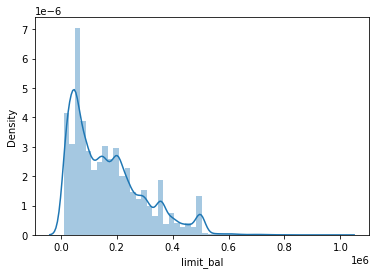

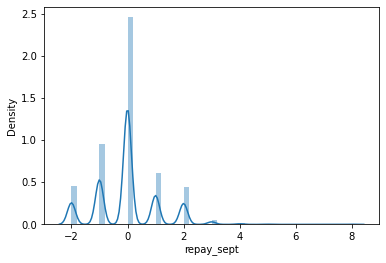

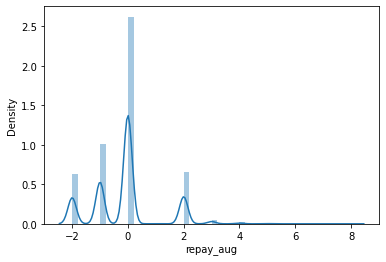

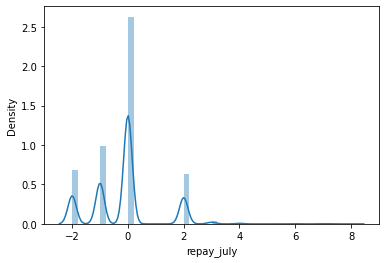

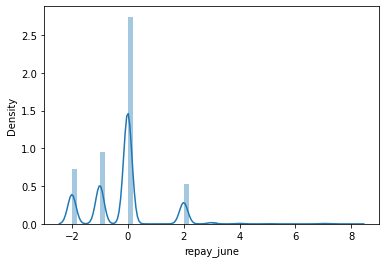

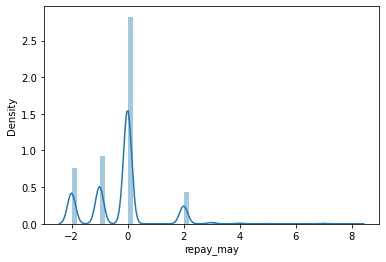

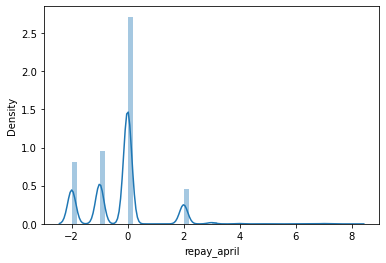

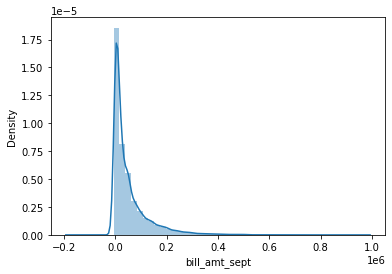

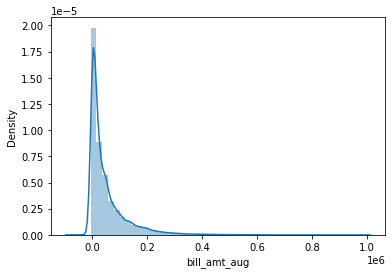

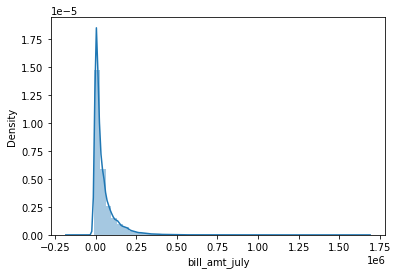

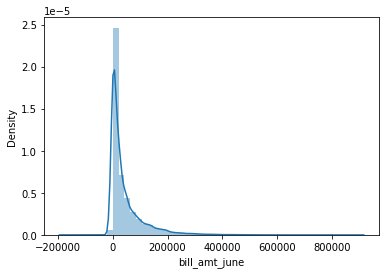

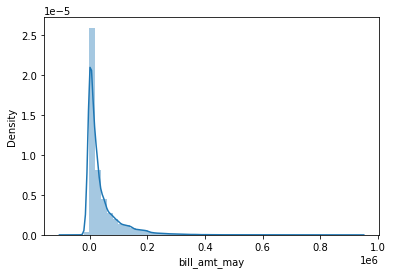

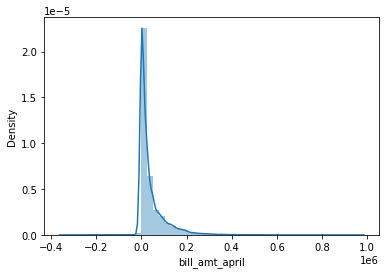

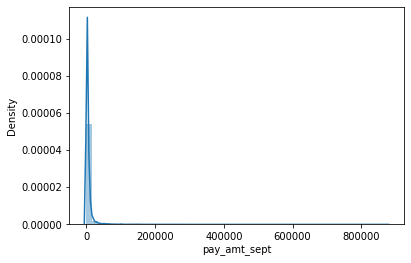

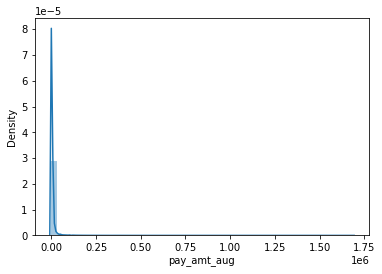

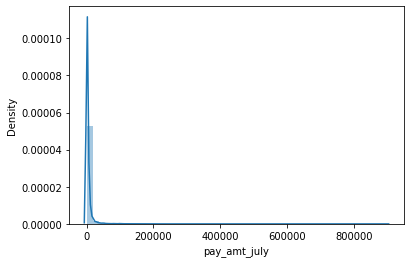

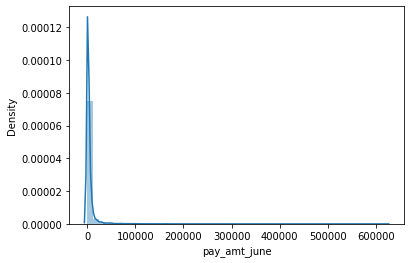

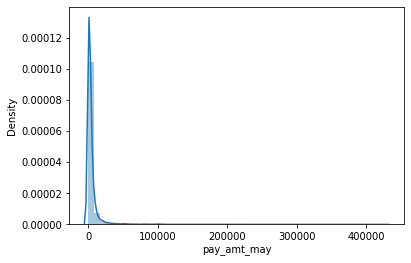

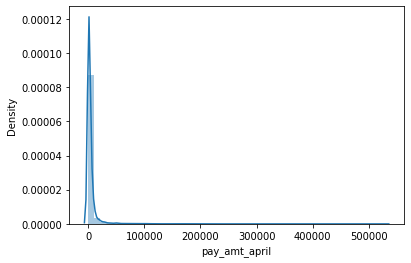

In [23]:
for col in all_col_cont:
    sb.distplot(df_credit[col])
    plt.show()

#### About the distribution plots above:

- For the "limit_bal" variable we can see that the given credit distribution is right skewed

- Regarding the distribution of repayment columns, it is possible to see that they are very similar every month, sepecially from April to August, where the majority of repaymentes correspond to -2 (no consumption), -1 (paid in full), 0 (paid on time) or 2 (payment delay for two months). However, in September the distribution is very similar, there is a significant amount of repayments with one month delay. In general terms, most of the people who have pending paymentes pay duly (zeros) . The most of the people that pay late, pay two months later.

- The "bill_amt" columns are right skewed as well. The mean values increase every month from April to September and so it does the standard deviation, which indicates that this columns can be influenced by outliers that can bias the data. In addition, **the minimum values of all these six columns are negative, which means that the people paid more than they were supposed to the month before.**

- The "pay_amt" colums have also a right skewed distribution and a very similar nature and magnitude if we compare them with each other.

In [24]:
col_list=['sex','education','marriage','age','dpnm','age_cat'] # in order to print the categorical variables

In [25]:
type(col_list)

list

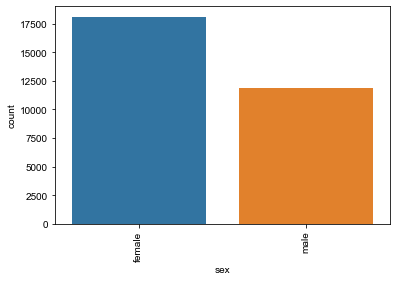

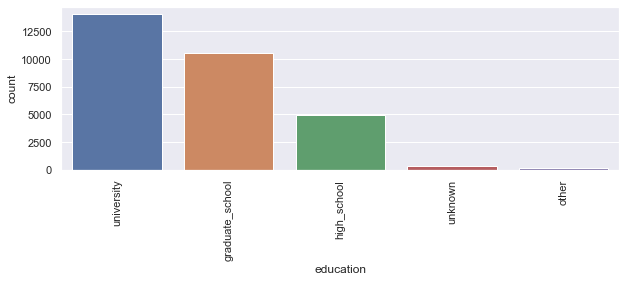

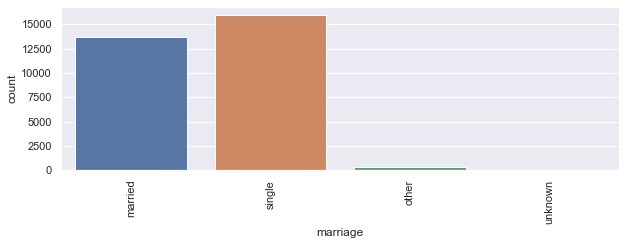

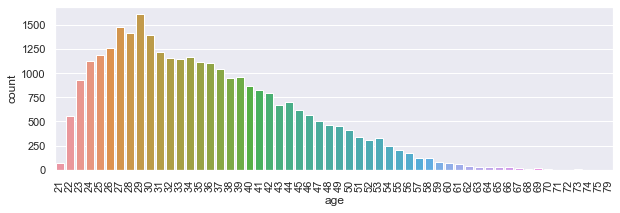

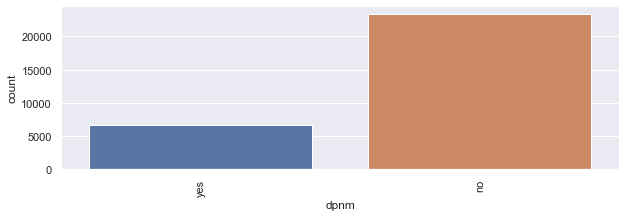

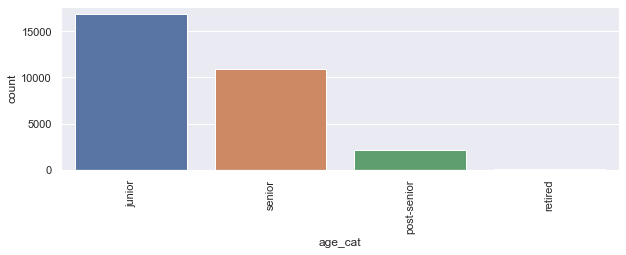

In [26]:
for col in col_list:
    g=sb.countplot(data=df_credit, x=col)
    sb.set(rc={'figure.figsize':(10,3)})
    plt.xticks(rotation=90)
    plt.show()

    

* Looking at the bar plots above, we can see that the most frequent person that is using a credit in this dataset is a univerity female student who will not default the payment the next month.

In [27]:
df_credit.head(2)

,limit_bal,sex,education,marriage,age,repay_sept,repay_aug,repay_july,repay_june,repay_may,repay_april,bill_amt_sept,bill_amt_aug,bill_amt_july,bill_amt_june,bill_amt_may,bill_amt_april,pay_amt_sept,pay_amt_aug,pay_amt_july,pay_amt_june,pay_amt_may,pay_amt_april,dpnm,age_cat
id,,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,female,university,married,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,yes,junior
2,120000,female,university,single,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,yes,junior


In [28]:
# df_credit.to_excel("cleaned_data.xlsx")

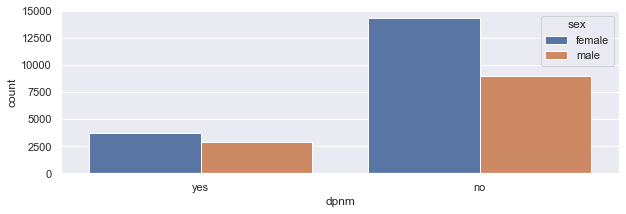

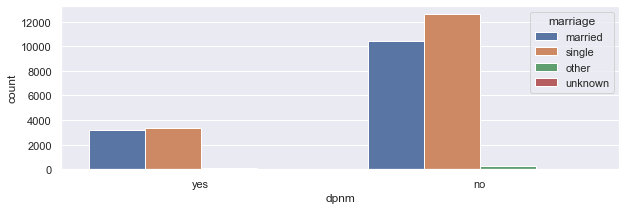

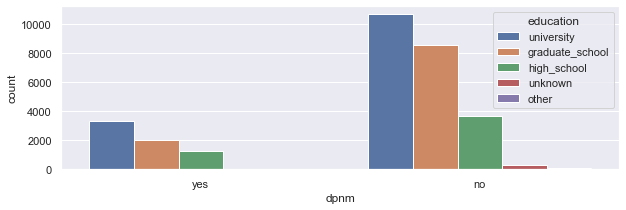

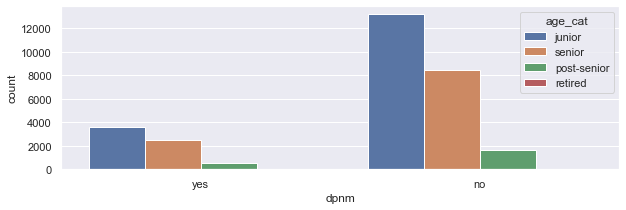

In [29]:
hue_list=['sex','marriage','education', 'age_cat']

for hue in hue_list:
    sb.countplot(data=df_credit, x='dpnm',hue=hue)
    plt.show();

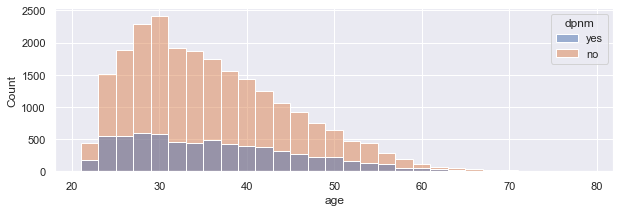

In [30]:
sb.histplot(data=df_credit, x="age", hue="dpnm",binwidth=2);

- Next we are going to visualize the distribution of "limit_bal" column (amount of given credit) by different categories (gender, marriage, age category and education).

In [31]:
df_credit.head(2)

,limit_bal,sex,education,marriage,age,repay_sept,repay_aug,repay_july,repay_june,repay_may,repay_april,bill_amt_sept,bill_amt_aug,bill_amt_july,bill_amt_june,bill_amt_may,bill_amt_april,pay_amt_sept,pay_amt_aug,pay_amt_july,pay_amt_june,pay_amt_may,pay_amt_april,dpnm,age_cat
id,,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,female,university,married,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,yes,junior
2,120000,female,university,single,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,yes,junior


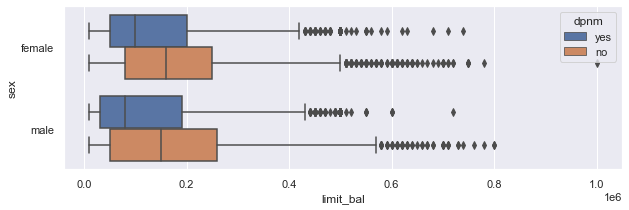

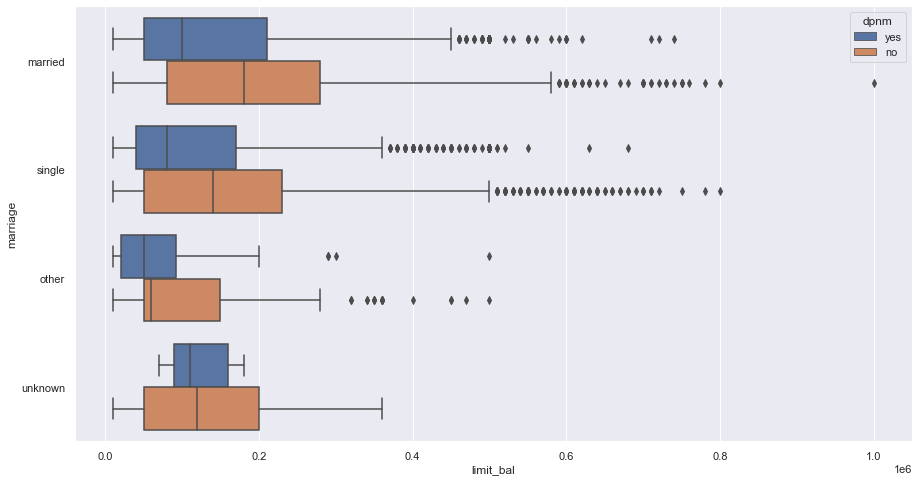

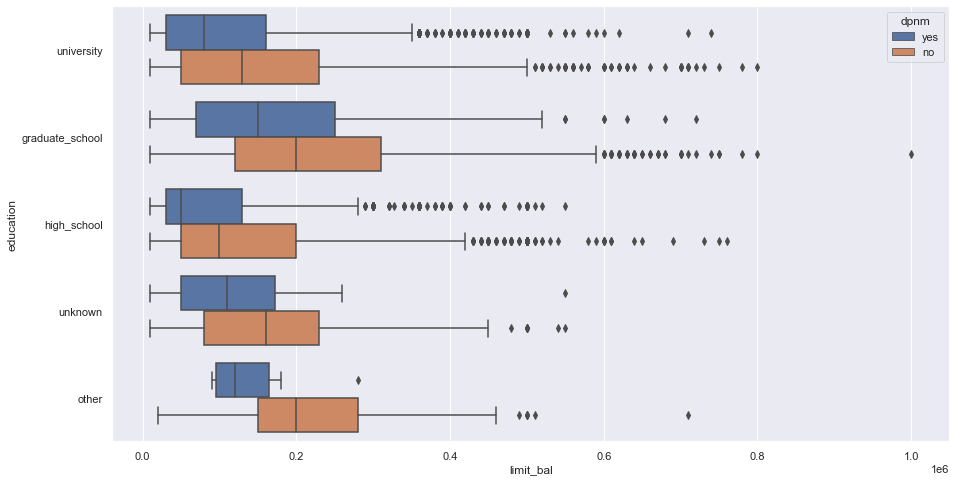

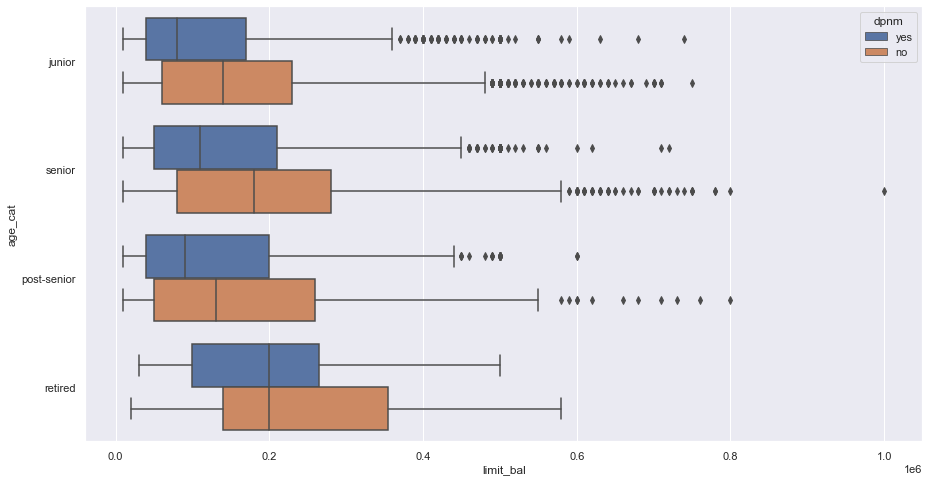

In [32]:
limit_cols=['sex','marriage','education','age_cat']
for col in limit_cols:
    
    sb.boxplot(data=df_credit , x='limit_bal',y=col , hue='dpnm')
    sb.set(rc={'figure.figsize':(15,8)})
    plt.show()

* Looking at the boxplots we can see that:
    - Both for male and female, the given credits are smaller when the default in the next month payment happen.
    - Regarding the marital status, we can see that the biggest amount of given credit correspond to married people and, as before, the amount of credit is smaller for default cases.
    - Acording to the education, it is suprising to see, how the biggest credit is provided to people that are graduated in school (and not at the university or in high school).
    - That the group of age that receives higher amount for the credits are the retired people followed by the "post-senior" and the "senior".
    
**We can see that the common trend is that the cases of default payment for the next month are in general smaller amount credits compare to those that are not deafault in the same category.**

In [33]:
df_credit.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'repay_sept',
       'repay_aug', 'repay_july', 'repay_june', 'repay_may', 'repay_april',
       'bill_amt_sept', 'bill_amt_aug', 'bill_amt_july', 'bill_amt_june',
       'bill_amt_may', 'bill_amt_april', 'pay_amt_sept', 'pay_amt_aug',
       'pay_amt_july', 'pay_amt_june', 'pay_amt_may', 'pay_amt_april', 'dpnm',
       'age_cat'],
      dtype='object')

* Next, we will creat a comparison between billing amount and paying amount by month and demographic group (sex, marriage, eduction and age category).

In [34]:
group_cols=['sex','marriage','education','age_cat']
bill_cols=['bill_amt_april','bill_amt_may','bill_amt_june','bill_amt_july','bill_amt_aug','bill_amt_sept']
pay_cols=['pay_amt_april','pay_amt_may','pay_amt_june','pay_amt_july','pay_amt_aug','pay_amt_sept']

TypeError: object of type 'generator' has no len()

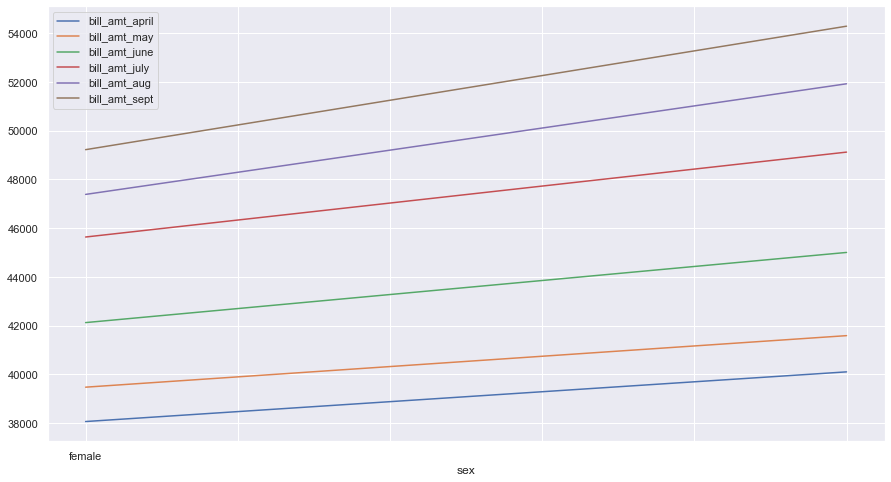

In [35]:
for colg in group_cols:
    df_bill=df_credit.groupby(colg)[bill_cols].mean()
    df_pay=df_credit.groupby(colg)[pay_cols].mean()
    ax = df_bill.plot()
    l = ax.get_lines()
    df_pay.plot(ax=ax, linestyle='--', color=(i.get_color() for i in l))
    plt.show()

In [ ]:
df_bill.head()

,bill_amt_april,bill_amt_may,bill_amt_june,bill_amt_july,bill_amt_aug,bill_amt_sept
age_cat,,,,,,
junior,37383.580463,38721.292938,41508.159141,44966.869832,46957.724493,48843.063002
post-senior,38760.803481,40903.335318,44630.071003,48939.778745,50939.190563,53110.830050
retired,75680.302326,73711.372093,77706.069767,78182.279070,84509.906977,90762.313953
senior,40894.421168,42377.280443,45419.122413,49531.891229,51967.749405,54197.983886


In [ ]:
df_bill_sex=df_credit.groupby('sex')[bill_cols].mean()
df_pay_sex=df_credit.groupby('sex')[pay_cols].mean()

df_bill_mar=df_credit.groupby('marriage')[bill_cols].mean()
df_pay_mar=df_credit.groupby('marriage')[pay_cols].mean()

df_bill_ed=df_credit.groupby('education')[bill_cols].mean()
df_pay_ed=df_credit.groupby('education')[pay_cols].mean()

df_bill_age=df_credit.groupby('age')[bill_cols].mean()
df_pay_age=df_credit.groupby('age')[pay_cols].mean()

In [ ]:
df_bill_sex.head()

,bill_amt_april,bill_amt_may,bill_amt_june,bill_amt_july,bill_amt_aug,bill_amt_sept
sex,,,,,,
female,38064.427286,39473.816807,42122.600099,45633.108989,47380.997736,49216.395263
male,40101.775320,41587.504963,45000.331090,49115.727961,51918.541723,54281.004038


In [ ]:
df_pay_sex.head()

,pay_amt_april,pay_amt_may,pay_amt_june,pay_amt_july,pay_amt_aug,pay_amt_sept
sex,,,,,,
female,5175.665305,4778.752043,4797.786992,5103.057255,5895.200088,5660.327076
male,5276.196753,4830.827052,4869.177995,5412.506057,5960.720138,5668.537264


In [ ]:
df_bill_mar.head()

,bill_amt_april,bill_amt_may,bill_amt_june,bill_amt_july,bill_amt_aug,bill_amt_sept
marriage,,,,,,
married,40250.686946,41975.121824,44891.819094,48981.229592,50925.088147,53258.129072
other,28582.696594,28269.250774,31230.300310,37212.554180,40048.777090,43176.012384
single,37974.720308,39207.970120,42194.771674,45621.441493,47955.188111,49749.414746
unknown,16815.425926,17719.203704,19007.222222,19253.370370,23964.777778,20400.611111


In [ ]:
df_pay_mar.head()

,pay_amt_april,pay_amt_may,pay_amt_june,pay_amt_july,pay_amt_aug,pay_amt_sept
marriage,,,,,,
married,5331.664836,4836.070503,5075.922469,5328.491983,6205.714401,5789.741562
other,3408.987616,4563.919505,5121.179567,6150.086687,7865.136223,6910.461300
single,5162.734340,4781.813581,4612.971185,5123.063518,5648.984465,5523.197194
unknown,2238.388889,2124.518519,2864.222222,4027.944444,2781.944444,7795.111111


In [ ]:
df_bill_ed.head()

,bill_amt_april,bill_amt_may,bill_amt_june,bill_amt_july,bill_amt_aug,bill_amt_sept
education,,,,,,
graduate_school,38668.076051,40388.891261,42931.065187,45781.689183,47219.101181,48825.437506
high_school,34704.597315,35957.469392,38718.582266,43440.916616,45520.299776,47563.546065
other,32136.130081,33840.113821,39570.268293,44983.804878,47308.967480,54631.902439
university,40431.943835,41588.566287,44748.779758,48662.161582,51359.611404,53605.533999
unknown,43466.104348,50355.997101,59105.368116,69372.005797,73450.446377,78861.881159


In [ ]:
df_pay_ed.head()

,pay_amt_april,pay_amt_may,pay_amt_june,pay_amt_july,pay_amt_aug,pay_amt_sept
education,,,,,,
graduate_school,6422.554842,5776.562211,5804.565612,6560.585735,7306.622201,6780.933585
high_school,3825.749034,3599.658938,3992.658532,3964.056742,5053.454139,4866.397397
other,4284.967480,5991.642276,5104.861789,9990.626016,6555.008130,5450.512195
university,4716.487028,4452.678689,4375.387313,4556.800000,5106.711333,5080.463293
unknown,8613.802899,5591.713043,4911.579710,7752.542029,8675.504348,6532.881159


In [ ]:
df_bill_age.head()

,bill_amt_april,bill_amt_may,bill_amt_june,bill_amt_july,bill_amt_aug,bill_amt_sept
age,,,,,,
21,7790.910448,11055.074627,12768.373134,14515.701493,16066.343284,16961.567164
22,15539.044643,16932.230357,19718.173214,22515.450000,23766.019643,24176.146429
23,21363.386681,22221.128894,23830.878625,26876.412460,28782.442535,29910.552095
24,25660.377107,26043.818101,27955.181899,31003.772848,32483.512866,33747.833185
25,30657.220067,31979.716695,34916.935919,38327.632378,40695.341484,41777.456998


In [ ]:
df_pay_age.head()

,pay_amt_april,pay_amt_may,pay_amt_june,pay_amt_july,pay_amt_aug,pay_amt_sept
age,,,,,,
21,568.208955,827.656716,1381.865672,1179.865672,1749.716418,2085.776119
22,1542.930357,1661.521429,1743.666071,1845.053571,2408.187500,2369.537500
23,2668.021482,2278.273899,2633.437164,2833.618690,3167.992481,3239.650913
24,2745.241349,2987.842946,2734.072760,2667.676131,3456.996451,3437.509317
25,3636.136594,2949.698988,3640.538786,3363.674536,3721.000000,4711.833895


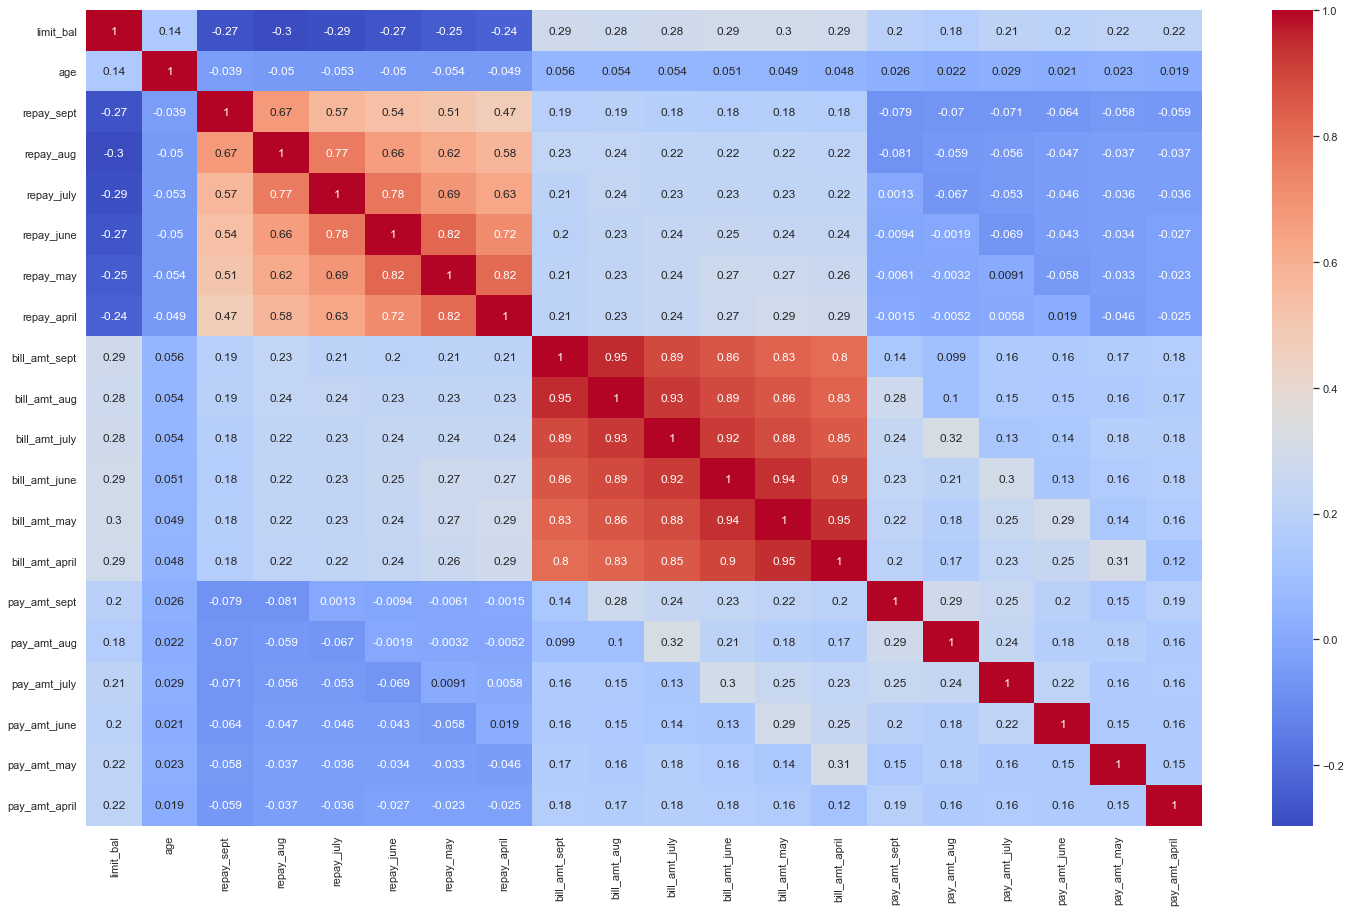

In [ ]:
df_credit_corr=df_credit.corr()
fig, ax = plt.subplots(figsize=(25,15))
sb.heatmap(df_credit_corr,annot=True,cmap="coolwarm" , ax=ax);

In [ ]:
df_credit_num=df_credit.select_dtypes('number') # to create a dataframe with numeric variables

In [ ]:
threshold=0.75
columns = np.full((df_credit_corr.shape[0],), True, dtype=bool)
for i in range(df_credit_corr.shape[0]):
    for j in range(i+1, df_credit_corr.shape[0]):
        if df_credit_corr.iloc[i,j] >= threshold:
            if columns[j]:
                columns[j] = False
selected_columns = df_credit_num.columns[columns]
selected_columns
df_credit_num = df_credit_num[selected_columns]

In [ ]:
df_credit_num.head()

,limit_bal,age,repay_sept,repay_aug,bill_amt_sept,pay_amt_sept,pay_amt_aug,pay_amt_july,pay_amt_june,pay_amt_may,pay_amt_april
id,,,,,,,,,,,
1,20000,24,2,2,3913,0,689,0,0,0,0
2,120000,26,-1,2,2682,0,1000,1000,1000,0,2000
3,90000,34,0,0,29239,1518,1500,1000,1000,1000,5000
4,50000,37,0,0,46990,2000,2019,1200,1100,1069,1000
5,50000,57,-1,0,8617,2000,36681,10000,9000,689,679


In order to be able to calculate the diference between the **bill_amt** columns and the **pay_amt** we are going to create a column with the sum of the for each category (*bill_amt_sum* and *pay_amt_sum*) and then we are going to calculate the difference (*bill_amt_tot-pay_amt_tot*). This way, we will be able to quantify the impact of a bad prediciction when not coceding a credit (that would have been paid) or when conceding a credit (that will not be paid).

In [ ]:
df_credit_bill_pay=pd.DataFrame()
df_credit_bill_pay['bill_amt_sum']=df_credit['bill_amt_sept']+df_credit['bill_amt_aug']+df_credit['bill_amt_july']+df_credit['bill_amt_june']+df_credit['bill_amt_may']+df_credit['bill_amt_april']

In [ ]:
df_credit_bill_pay['pay_amt_sum']=df_credit['pay_amt_sept']+df_credit['pay_amt_aug']+df_credit['pay_amt_july']+df_credit['pay_amt_june']+df_credit['pay_amt_may']+df_credit['pay_amt_april']

In [ ]:
df_credit_bill_pay['bill_pay_diff']=df_credit_bill_pay['bill_amt_sum']-df_credit_bill_pay['pay_amt_sum']

In [ ]:
df_credit_bill_pay.drop(columns=['bill_amt_sum', 'pay_amt_sum'],inplace=True)

In [ ]:
df_credit_bill_pay.head(2) # With the calculated values, we are going to calculate the impact of the mistakes of the model in
# profits of the bank.

,bill_pay_diff
id,
1,7015
2,12077


In [ ]:
df_credit_cat_targ=df_credit.select_dtypes('object') # to build a dataframe with the categoricals
df_credit_cat=df_credit_cat_targ.drop(columns=['age_cat','dpnm'])

* Next we will have to standarize the numeric variables.

In [ ]:
scaler=StandardScaler()
scaled=scaler.fit_transform(df_credit_num)
df_cred_num_st=pd.DataFrame(scaled,columns=df_credit_num.columns)
filename = 'scaled_model.sav'
pickle.dump(scaled, open(filename, 'wb'))

In [ ]:
df_cred_num_st.head(2)

,limit_bal,age,repay_sept,repay_aug,bill_amt_sept,pay_amt_sept,pay_amt_aug,pay_amt_july,pay_amt_june,pay_amt_may,pay_amt_april
0,-1.136720,-1.246020,1.794564,1.782348,-0.642501,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382
1,-0.365981,-1.029047,-0.874991,1.782348,-0.659219,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878


* Now we are going to encode the categorical variables

In [ ]:
encoder=OneHotEncoder(handle_unknown='error', drop='first')
encoder1=encoder.fit(df_credit_cat)
encoded = encoder1.transform(df_credit_cat).toarray()

filename = 'encoder_model.sav'
pickle.dump(encoded, open(filename, 'wb'))

In [ ]:
df_credit_cat

,sex,education,marriage
id,,,
1,female,university,married
2,female,university,single
3,female,university,single
4,female,university,married
5,male,university,married
...,...,...,...
29996,male,high_school,married
29997,male,high_school,single
29998,male,university,single


In [ ]:
X=np.concatenate([df_cred_num_st,encoded], axis=1)
y=df_credit['dpnm']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
y_test_calculate=y_test.reset_index()
y_test_calculate.head() 

,id,dpnm
0,2309,no
1,22405,no
2,23398,no
3,25059,no
4,2665,yes


In [ ]:
keep_cols=['id','bill_pay_diff']
df_credit_bill_pay.reset_index(inplace=True)
df_credit_bill_pay=df_credit_bill_pay[keep_cols]
df_credit_bill_pay.head()

,id,bill_pay_diff
0,1,7015
1,2,12077
2,3,90635
3,4,222946
4,5,50290


In [ ]:
df_bill_pay_test = pd.merge(df_credit_bill_pay, y_test_calculate, on='id', how='inner') 

In [ ]:
df_bill_pay_test.shape

(9000, 3)

In [ ]:
df_bill_pay_test.head()

,id,bill_pay_diff,dpnm
0,4,222946,no
1,7,2543836,no
2,8,8695,no
3,18,604117,no
4,24,4376,yes


* **We have created a dataframe with the y_test (target variable) and the amount of money we have assigned to each occurence in order to be able to measure/quantify the consequence of a good and a bad prediction.**

Next thing, will be to compare the target variable column (**dpnm**) with the predicted value in every model.

### Balancing data: SMOTE ant Tomek Links
* As the data is imbalanced (22,1% "yes" and 77,9% "no") we are going to upsample the date by using Synthetic Minority Oversampling Technique (SMOTE), which will add  new points between existing points based on nearest neighbors. Additionally, we are going to use the Tomek Links undersampling method in order to check with which we get better results.

In [ ]:
smote=SMOTE()

In [ ]:
def get_true_false(y_true, y_pred):


    tp = np.sum(np.logical_and(y_pred == 'yes', y_true == 'yes'))
    tn = np.sum(np.logical_and(y_pred == 'no', y_true == 'no'))
    fp = np.sum(np.logical_and(y_pred == 'yes', y_true == 'no'))
    fn = np.sum(np.logical_and(y_pred == 'no', y_true == 'yes'))
    
    print ("The amount of true positives is: {}.".format(tp))
    print ("The amount of true negatives is: {}.".format(tn))
    print ("The amount of false positives is: {}.".format(fp))
    print ("The amount of false negatives is: {}.".format(fn))
           

In [ ]:
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
y_train_sm.value_counts()

no     16324
yes    16324
Name: dpnm, dtype: int64

* The next step will be to calculate the metrics using the Logistic Regression model.

In [ ]:
classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train_sm, y_train_sm)

y_sm_pred_lg = classification.predict(X_test)
print(classification_report(y_test, y_sm_pred_lg))

              precision    recall  f1-score   support

          no       0.88      0.69      0.77      7040
         yes       0.37      0.65      0.47      1960

    accuracy                           0.68      9000
   macro avg       0.62      0.67      0.62      9000
weighted avg       0.76      0.68      0.71      9000



In [ ]:
get_true_false(y_test, y_sm_pred_lg) # SMOTE

The amount of true positives is: 1271.
The amount of true negatives is: 4850.
The amount of false positives is: 2190.
The amount of false negatives is: 689.


In [ ]:
tomek = TomekLinks()
X_train_tl, y_train_tl = tomek.fit_resample(X_train, y_train)
y_train_tl.value_counts()

no     15040
yes     4676
Name: dpnm, dtype: int64

In [ ]:
# Tomek links
classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train_tl, y_train_tl)

y_tl_pred_lg = classification.predict(X_test)
print(classification_report(y_test, y_tl_pred_lg))

              precision    recall  f1-score   support

          no       0.83      0.95      0.89      7040
         yes       0.64      0.33      0.43      1960

    accuracy                           0.81      9000
   macro avg       0.74      0.64      0.66      9000
weighted avg       0.79      0.81      0.79      9000



In [ ]:
get_true_false(y_test, y_tl_pred_lg) # Tomek links

The amount of true positives is: 638.
The amount of true negatives is: 6682.
The amount of false positives is: 358.
The amount of false negatives is: 1322.


* Using Decision Trees:

In [ ]:
#SMOTE
class_dt = DecisionTreeClassifier(criterion="gini", random_state=42,max_depth=2, min_samples_leaf=5)   
class_dt.fit(X_train_sm,y_train_sm)

y_pred_dt = class_dt.predict(X_test)
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

          no       0.86      0.85      0.86      7040
         yes       0.49      0.52      0.50      1960

    accuracy                           0.78      9000
   macro avg       0.68      0.68      0.68      9000
weighted avg       0.78      0.78      0.78      9000



In [ ]:
get_true_false(y_test, y_pred_dt) # SMOTE

The amount of true positives is: 1010.
The amount of true negatives is: 6001.
The amount of false positives is: 1039.
The amount of false negatives is: 950.


In [ ]:
# MODEL WE WANT TO EXPORT THROUGH PICKLE
classification_best = DecisionTreeClassifier(criterion="gini", random_state=42,max_depth=2, min_samples_leaf=5)
classification_best.fit(X_train_tl, y_train_tl)

y_tl_pred_dt = classification_best.predict(X_test)

filename = 'finalized_model.sav'
pickle.dump(classification_best, open(filename, 'wb'))
print(classification_report(y_test, y_tl_pred_dt)) # Tomek Links

              precision    recall  f1-score   support

          no       0.83      0.96      0.89      7040
         yes       0.70      0.31      0.43      1960

    accuracy                           0.82      9000
   macro avg       0.77      0.64      0.66      9000
weighted avg       0.80      0.82      0.79      9000



In [ ]:
get_true_false(y_test, y_tl_pred_dt) # Tomek Links

The amount of true positives is: 609.
The amount of true negatives is: 6775.
The amount of false positives is: 265.
The amount of false negatives is: 1351.


* Using Random Forests:

In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train_sm, y_train_sm)

y_pred_rf = model.predict(X_test)
print(classification_report(y_test, y_pred_rf)) # SMOTE

              precision    recall  f1-score   support

          no       0.85      0.88      0.87      7040
         yes       0.51      0.46      0.48      1960

    accuracy                           0.79      9000
   macro avg       0.68      0.67      0.67      9000
weighted avg       0.78      0.79      0.78      9000



In [ ]:
X_test

array([[-1.05964618, -1.13753351,  0.01486052, ...,  0.        ,
         1.        ,  0.        ],
       [-0.13475861, -1.02904717,  0.01486052, ...,  0.        ,
         1.        ,  0.        ],
       [-0.75135032, -0.37812914,  0.01486052, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.59720239, -0.05267012,  0.01486052, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.40475915,  0.05581622,  0.01486052, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.63598104,  0.05581622, -1.76484282, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
get_true_false(y_test, y_pred_rf) # SMOTE

The amount of true positives is: 902.
The amount of true negatives is: 6176.
The amount of false positives is: 864.
The amount of false negatives is: 1058.


In [ ]:
classification = RandomForestClassifier(random_state=42)
classification.fit(X_train_tl, y_train_tl)

y_tl_pred_rf = classification.predict(X_test)
print(classification_report(y_test, y_tl_pred_rf)) # Tomek links

              precision    recall  f1-score   support

          no       0.85      0.93      0.89      7040
         yes       0.61      0.40      0.48      1960

    accuracy                           0.81      9000
   macro avg       0.73      0.67      0.69      9000
weighted avg       0.80      0.81      0.80      9000



In [ ]:
get_true_false(y_test, y_tl_pred_rf) # Tomek links

The amount of true positives is: 789.
The amount of true negatives is: 6535.
The amount of false positives is: 505.
The amount of false negatives is: 1171.


#### - Now we are going to generate a dataframe with all the predictions from the different models and the upsampling and downsampling techniques. This way we are going to quantify which model would maximize the earnings of the bank.

In [ ]:
df_pred_mod=pd.DataFrame()
predict_list=[y_sm_pred_lg,y_tl_pred_lg,y_pred_dt,y_tl_pred_dt,y_pred_rf,y_tl_pred_rf]
pred_columns=['y_sm_pred_lg','y_tl_pred_lg','y_pred_dt','y_tl_pred_dt','y_pred_rf','y_tl_pred_rf']

for i in range(len(pred_columns)):
    df_pred_mod[pred_columns[i]]=predict_list[i]

df_pred_mod.head(10), df_pred_mod.shape

(  y_sm_pred_lg y_tl_pred_lg y_pred_dt y_tl_pred_dt y_pred_rf y_tl_pred_rf
 0          yes           no        no           no        no           no
 1           no           no        no           no        no           no
 2           no           no        no           no        no           no
 3          yes           no        no           no        no           no
 4           no           no        no           no        no           no
 5           no           no        no           no        no           no
 6          yes           no       yes           no        no          yes
 7          yes           no       yes           no        no           no
 8           no           no        no           no        no           no
 9           no           no        no           no        no           no,
 (9000, 6))

In [ ]:
df_bill_pay_test.shape

(9000, 3)

In [125]:
df_profit = pd.concat([df_bill_pay_test, df_pred_mod], axis=1, join='inner')
df_profit.head(20)

,id,bill_pay_diff,dpnm,y_sm_pred_lg,y_tl_pred_lg,y_pred_dt,y_tl_pred_dt,y_pred_rf,y_tl_pred_rf
0,4,222946,no,yes,no,no,no,no,no
1,7,2543836,no,no,no,no,no,no,no
2,8,8695,no,no,no,no,no,no,no
3,18,604117,no,yes,no,no,no,no,no
4,24,4376,yes,no,no,no,no,no,no
5,30,90482,no,no,no,no,no,no,no
6,31,16257,no,yes,no,yes,no,no,yes
7,35,12893,no,yes,no,yes,no,no,no
8,36,23032,no,no,no,no,no,no,no
9,42,373514,no,no,no,no,no,no,no


In [ ]:
df_profit[df_profit['bill_pay_diff']<0]['dpnm'].value_counts()
# As we can see below, about the 84% of the negative values in the "bill_pay_diff" column will pay.
# In order to handle the negative sign of this value, we are going to convert it to an absolute value.

no     798
yes    155
Name: dpnm, dtype: int64

In [ ]:
df_profit['bill_pay_diff']=df_profit['bill_pay_diff'].abs() # convert 'bill_pay_diff' to absolute values

*Having this table with the y_test/target variable for testing ("dpnm") and the predictions that made the model, we are going to define the weight of each type of mistake, depending on if the mistake is a **false positive** or a **false negative**, since they have a different impact in the earnings and losses. A false positive indicates that the client is going to default the payment but actually he is not, so probably the bank will not concede a credit the next time to a person with these features. This would cause an impact in the earnings because the bank would not earn the money for this potential client. Regarding the false negatives, they would be specially harmful because the model would be predicting that the client will not default the payment but actually he will default, so the bank would give a credit to a person who will not pay and the bank will lose the money for it.* For both of these situations we are going to provide a negative coefficient to take into account a **loss**.
On the other hand, for the right predicted situations (**true positives** and **true negatives**), the coefficients will be positive, as they would bring a direct **profit**.

In [ ]:
df_profit.to_excel("df_profit.xlsx")

In [ ]:
def calc_prof(y_pred, y_test,profit):
    
    if ((y_pred=='yes') and (y_test=='yes')): # True Positives. Positive impact in the profit of the bank.
        return (profit)

    elif ((y_pred=='no') and (y_test=='no')): # True Negatives. Positive impact in the profit of the bank.
        return (profit*(0.3))

    elif ((y_pred=='no') and (y_test=='yes')): # False Negative. It will generate losses.
        return (profit*(-1))

    elif ((y_pred=='yes') and (y_test=='no')): # False Positive. It will generate losses.
        return (profit*(-0.3))
        
    

In [ ]:
cal_columns=['y_sm_pred_lg_cal','y_tl_pred_lg_cal','y_pred_dt_cal','y_tl_pred_dt_cal','y_pred_rf_cal','y_tl_pred_rf_cal']
pred_columns=['y_sm_pred_lg','y_tl_pred_lg','y_pred_dt','y_tl_pred_dt','y_pred_rf','y_tl_pred_rf']

In [ ]:
for i in range(len(predict_list)):
    df_profit[cal_columns[i]]=df_profit.apply(lambda x:calc_prof(x[pred_columns[i]],x['dpnm'],x['bill_pay_diff']),axis=1)

In [ ]:
df_profit.head()

,id,bill_pay_diff,dpnm,y_sm_pred_lg,y_tl_pred_lg,y_pred_dt,y_tl_pred_dt,y_pred_rf,y_tl_pred_rf,y_sm_pred_lg_cal,y_tl_pred_lg_cal,y_pred_dt_cal,y_tl_pred_dt_cal,y_pred_rf_cal,y_tl_pred_rf_cal
0,4,222946,no,yes,no,no,no,no,no,-66883.8,66883.8,66883.8,66883.8,66883.8,66883.8
1,7,2543836,no,no,no,no,no,no,no,763150.8,763150.8,763150.8,763150.8,763150.8,763150.8
2,8,8695,no,no,no,no,no,no,no,2608.5,2608.5,2608.5,2608.5,2608.5,2608.5
3,18,604117,no,yes,no,no,no,no,no,-181235.1,181235.1,181235.1,181235.1,181235.1,181235.1
4,24,4376,yes,no,no,no,no,no,no,-4376.0,-4376.0,-4376.0,-4376.0,-4376.0,-4376.0


In [ ]:
col_values=[]
for col in cal_columns:
    print("The mean profit by customer in the model {} is: {}".format(col, round(df_profit[col].mean(),2)))
    col_values.append(round(df_profit[col].mean(),2))

The mean profit by customer in the model y_sm_pred_lg_cal is: 1414.48
The mean profit by customer in the model y_tl_pred_lg_cal is: 4604.35
The mean profit by customer in the model y_pred_dt_cal is: 1606.04
The mean profit by customer in the model y_tl_pred_dt_cal is: 5398.33
The mean profit by customer in the model y_pred_rf_cal is: 4360.81
The mean profit by customer in the model y_tl_pred_rf_cal is: 4381.03


In [ ]:
maximum_profit=max(col_values) # The greatest calculated profit amount
maximum_profit

5398.33

In [ ]:
maximum_position=col_values.index(maximum_profit) # The position of the maximum value in the list
maximum_position

3

In [ ]:
most_prof_model=cal_columns[maximum_position] # The model that return the greatest profit.
most_prof_model

'y_tl_pred_dt_cal'

## Conclusion

* Looking at the results above, it is possible to see that the model that would maximize the profits of the bank would be the one built with Decision Trees and using the Tomek Links downsampling method. In addition, the results show that the Tomek Links method is more effective than SMOTE for balancing the data except for Random Forest´s model, that generates better results with SMOTE. 


* It is mandatory to highlight, that in terms of metrics the Random Forests and Decision Trees are very similar and also the Logistic Regression when using Tomek Links but there are some differences in which they are able to predict better, since some mistakes or good predictions influence more the final result, hence the bank´s average profit by customer as a metric to compare the effectiveness of the predictions of every model.

* As explaind before in this notebook, each type of mistake, depending on if it is a **false positive** or a **false negative**, will have a different impact in the earnings and losses. A false positive indicates that the client is going to default the payment but actually he is not, so probably the bank will not concede a credit the next time to a person with these features. This would cause an impact in the earnings because the bank would not earn the money for this potential client. Regarding the false negatives, they would be specially harmful because the model would be predicting that the client will not default the payment but actually he will default, so the bank would give a credit to a person who will not pay and the bank will lose the money for it.* For both of these situations we are going to provide a negative coefficient to take into account a **loss**.

* On the other hand, for the right predicted situations (**true positives** and **true negatives**), the coefficients will be positive, as they would bring a direct **profit**.